In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

# 1.查看数据是否有缺失值

In [5]:
import seaborn as sns
sns.set(style='whitegrid' , palette='tab10')

train = pd.read_csv('train.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
test=pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


本数据集没有缺失数据，但没有缺失不代表没有异常。

## 1.2检查异常值

In [7]:
#观察训练集数据描述统计
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


先从数值型数据入手，可以看出租赁额（count）数值差异大，所以希望观察一下它们的密度分布

[Text(0.5, 0, 'count'), Text(0.5, 1.0, 'Density distribution of count')]

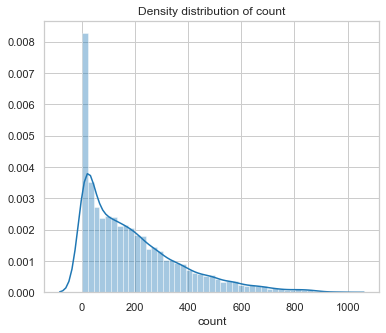

In [8]:
#观察数据密度分布情况
fig = plt.figure()
ax = fig.add_subplot(1,1,1) # 1*1网格，第一个子图
fig.set_size_inches(6,5) # 设置图像大小
# 详见核密度估计https://www.zhihu.com/question/27301358
# displot()集合了matplotlib的hist()与核函数估计kdeplot的功能，默认是hist,True是kde
sns.distplot(train['count']) 
#核密度估计是在概率论中用来估计未知的密度函数，属于非参数检验方法之一。
#由于核密度估计方法不利用有关数据分布的先验知识，对数据分布不附加任何假定，是一种从数据样本本身出发研究数据分布特征的方法，
#因而，在统计学理论和应用领域均受到高度的重视。
ax.set(xlabel='count',title = 'Density distribution of count')

发现数据密度分布的偏斜比较严重，且有一个很长的尾，所以希望能把这一列数据的长尾处理一下，排除掉3个标准差以外的数据

In [9]:
train_without_outliers = train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())] 
train_without_outliers.shape

(10739, 12)

观察去除3个标准差之后的租赁额统计描述

In [10]:
train_without_outliers['count'] .describe()

count    10739.000000
mean       183.003818
std        166.681429
min          1.000000
25%         41.000000
50%        141.000000
75%        276.000000
max        734.000000
Name: count, dtype: float64

[Text(0.5, 0, 'registered'), Text(0.5, 1.0, 'Density distribution of count')]

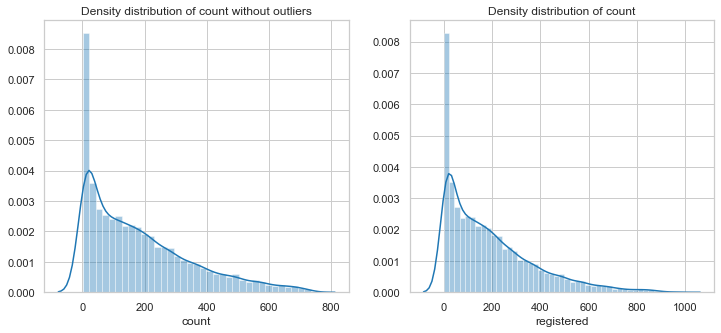

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.set_size_inches(12,5)
# ax表示位置
sns.distplot(train_without_outliers['count'],ax=ax1)
sns.distplot(train['count'],ax=ax2)

ax1.set(xlabel='count',title='Density distribution of count without outliers',)
ax2.set(xlabel='registered',title='Density distribution of count')


可以看到数据波动依然很大，而我们希望波动相对稳定，否则容易产生过拟合，

所以希望对数据进行变换，使得数据相对稳定，选择对数变化，来完成这项任务。

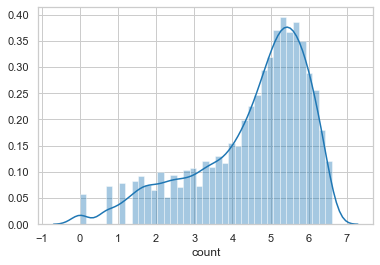

In [12]:
"""从上图可以看出，数据波动依旧很大，需要进一步处理，使波动相对稳定，否则容易产生过拟合"""
y_label = train_without_outliers['count']
y_label_log = np.log(y_label)
sns.distplot(y_label_log)

经过对count做对数处理之后，数据分布较为均匀，缩小大小差异，对后续训练模型有益处
其次需要将对剩余的数据型数据进行处理，其他数据同时包含在两个数据集中，为了方便数据处理先合并

In [13]:
bike_data = pd.concat([train_without_outliers,test],ignore_index=True)
bike_data.shape

(17232, 12)

In [14]:
bike_data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


因为最终需要使用随机森林预测，并且为了方便查可视化数据，先把datetime拆分成成日期、时段、年份、月份、星期五列

In [15]:
# apply(func, axis=0, broadcast=False, raw=False, reduce=None, args=(), **kwds)
bike_data['date'] = bike_data.datetime.apply(lambda c : c.split()[0])
bike_data['hour']=bike_data.datetime.apply( lambda c : c.split()[1].split(':')[0]).astype('int')
bike_data['year']=bike_data.datetime.apply( lambda c : c.split()[0].split('-')[0]).astype('int')
bike_data['month']=bike_data.datetime.apply( lambda c : c.split()[0].split('-')[1]).astype('int')
bike_data['weekday']=bike_data.date.apply( lambda c : datetime.strptime(c,'%Y-%m-%d').isoweekday())
bike_data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,month,weekday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,0,2011,1,6
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,1,2011,1,6
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011-01-01,2,2011,1,6
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011-01-01,3,2011,1,6
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011-01-01,4,2011,1,6


观察上面的数据可以看到temp（温度），atemp（体感温度），humidity（湿度）、windspeed（风速）这四列也属于数值型数据，同样可以查看一下它们的分布。

[Text(0.5, 0, 'windspeed'),
 Text(0.5, 1.0, 'Density distribution of windspeed')]

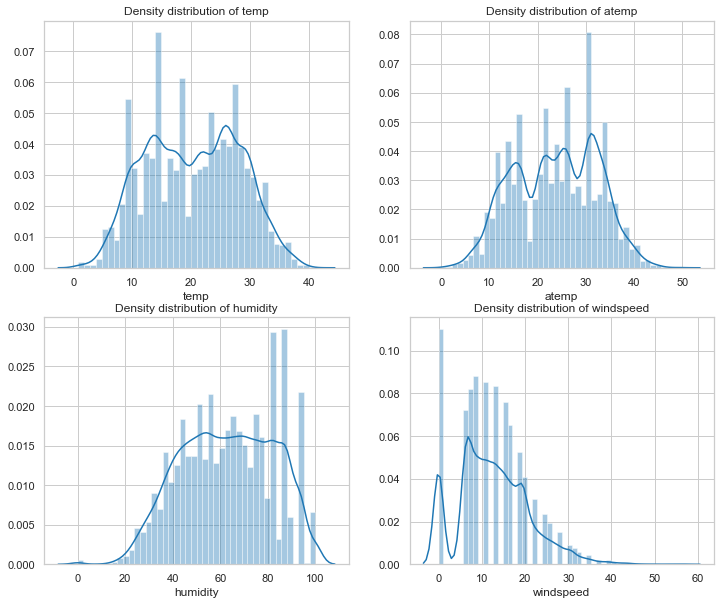

In [16]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12,10)

sns.distplot(bike_data['temp'],ax=axes[0,0])
sns.distplot(bike_data['atemp'],ax=axes[0,1])
sns.distplot(bike_data['humidity'],ax=axes[1,0])
sns.distplot(bike_data['windspeed'],ax=axes[1,1])

axes[0,0].set(xlabel='temp',title='Density distribution of temp',)
axes[0,1].set(xlabel='atemp',title='Density distribution of atemp')
axes[1,0].set(xlabel='humidity',title='Density distribution of humidity')
axes[1,1].set(xlabel='windspeed',title='Density distribution of windspeed')

通过这个分布可以发现一些问题，比如风速为什么0的数据很多，
而观察统计描述发现空缺值在1--6之间，从这里似乎可以推测，数据本身或许是有缺失值的，
但是用0来填充了，但这些风速为0的数据会对预测产生干扰，可以使用随机森林根据相同的年份，月份，季节，温度，湿度等几个特征来填充一下风速的缺失值。填充之前的非零数据的描述统计。

In [17]:

bike_data[bike_data['windspeed']!=0]['windspeed'].describe()

count    15068.000000
mean        14.556762
std          7.092624
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

In [18]:
# 使用随机森林填充风速
from sklearn.ensemble import RandomForestRegressor
bike_data['windspeed_rfr'] = bike_data['windspeed']
# 将数据分成风速等于0和不等于两部分
data_wind_zero = bike_data[bike_data['windspeed_rfr']==0]
data_wind_not_zero = bike_data[bike_data['windspeed_rfr']!=0]
#选定模型
rf_model_wind = RandomForestRegressor(n_estimators=10,random_state=42)
#选定特征值
wind_colums = ["season","weather","humidity","month","temp","year","atemp"]
# 将风速不等于0的数据作为训练集，fit到RandomForestRegressor之中
rf_model_wind.fit(data_wind_not_zero[wind_colums], data_wind_not_zero["windspeed_rfr"])
#通过训练好的模型预测风速
wind_zero_values = rf_model_wind.predict(X=data_wind_zero[wind_colums])
#将预测的风速填充到风速为零的数据中
data_wind_zero.loc[:,"windspeed_rfr"] = wind_zero_values
#连接两部分数据
bike_data = data_wind_not_zero.append(data_wind_zero)
bike_data.reset_index(inplace=True)
bike_data.drop('index',inplace=True,axis=1)

[Text(0.5, 0, 'windseed'), Text(0.5, 1.0, 'Density distribution of windspeed')]

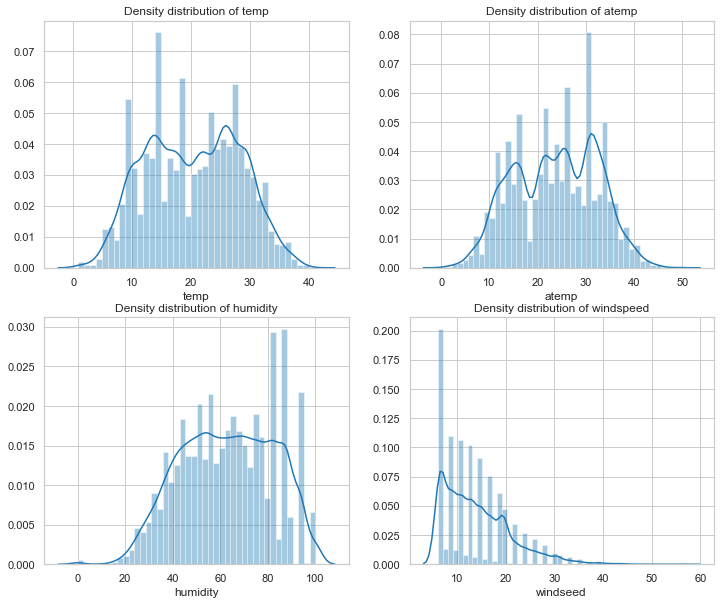

In [19]:
# 填充好再画图观察一下这四个特征值的密度分布
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12,10)

sns.distplot(bike_data['temp'],ax=axes[0,0])
sns.distplot(bike_data['atemp'],ax=axes[0,1])
sns.distplot(bike_data['humidity'],ax=axes[1,0])
sns.distplot(bike_data['windspeed_rfr'],ax=axes[1,1])

axes[0,0].set(xlabel='temp',title='Density distribution of temp',)
axes[0,1].set(xlabel='atemp',title='Density distribution of atemp')
axes[1,0].set(xlabel='humidity',title='Density distribution of humidity')
axes[1,1].set(xlabel='windseed',title='Density distribution of windspeed')

# 2.分析数据
## 2.1 整体观察
问题是希望预测每小时总租赁额，首先整体看一下租赁额相关的三个值和其他特征值的关系。

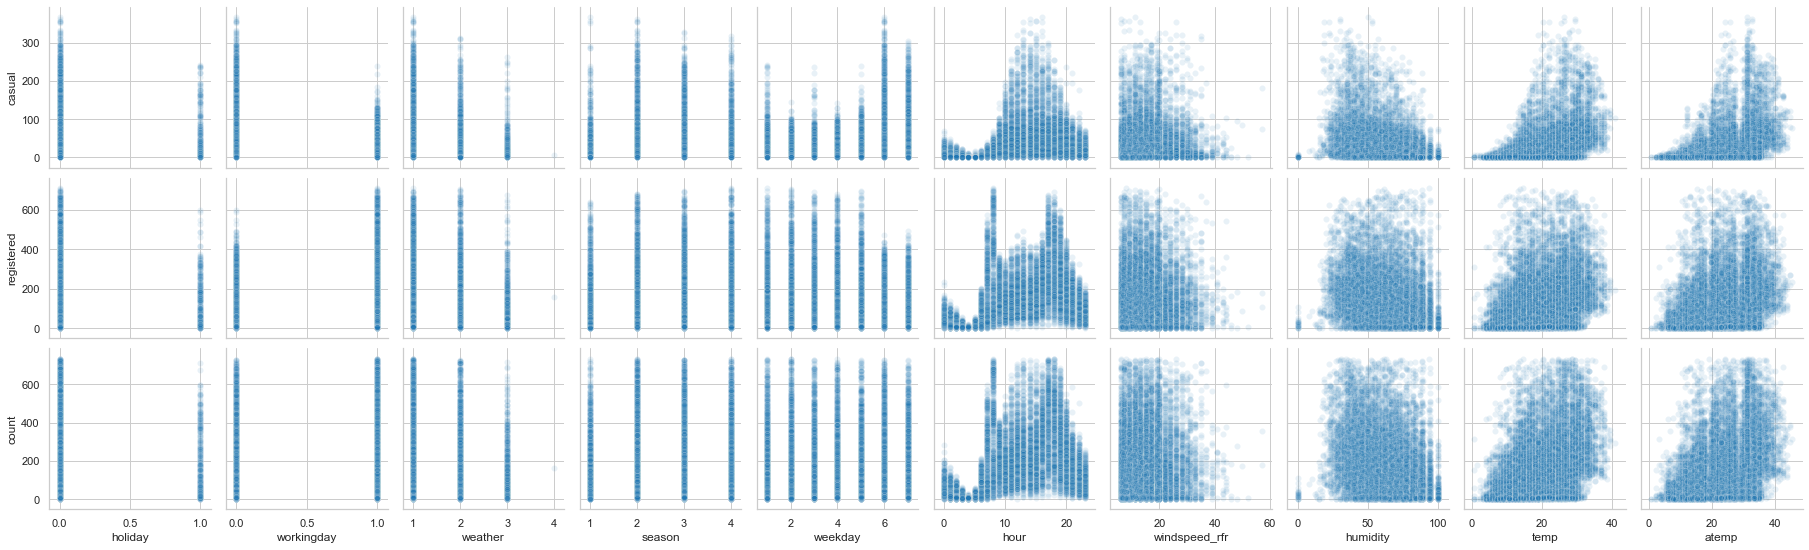

In [20]:
sns.pairplot(bike_data,x_vars = ['holiday','workingday','weather','season',
                                'weekday','hour','windspeed_rfr','humidity','temp','atemp'],
                        y_vars = ['casual','registered','count'],plot_kws={'alpha':0.1})

1.会员在工作日出行多，节假日出行少，临时用户则相反；

2.一季度出行人数总体偏少；

3.租赁数量随天气等级上升而减少；

4.小时数对租赁情况影响明显，会员呈现两个高峰，非会员呈现一个正态分布；

5.租赁数量随风速增大而减少；

6.温度、湿度对非会员影响比较大，对会员影响较小

下面查看各个特征与每小时租车总量（count）的相关性，由于上图可以看出特征值与租车数量基本是线性相关，所以求他们的线性相关系数

In [21]:
# 相关性矩阵
corr_df = bike_data.corr()
# 按照降序排列
corr_df['count'].sort_values(ascending =False)


count            1.000000
registered       0.966209
casual           0.704764
hour             0.405437
temp             0.385954
atemp            0.381967
year             0.234959
month            0.164673
season           0.159801
windspeed_rfr    0.112299
windspeed        0.106074
weekday          0.022602
holiday          0.002978
workingday      -0.020764
weather         -0.127519
humidity        -0.317028
Name: count, dtype: float64

可以看出特征值对租赁数量的影响力度为,时段>温度>湿度>年份>月份>季节>天气等级>风速>星期几>是否工作日>是否假日，接下来再看一下共享单车整体使用情况。


## 2.2 逐项展示

### 2.2.1 时段对租赁数量的影响

因为时段对租赁数量的影响最大首先展示这一项数据

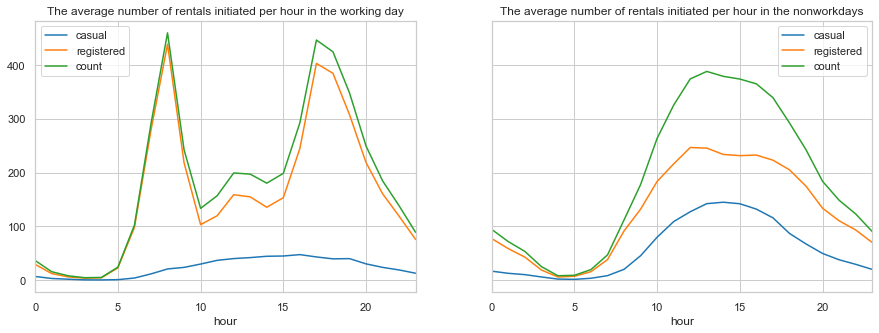

In [22]:
# 时段对租赁数量的影响
workingday_df = bike_data[bike_data['workingday']==1]
workingday_df = workingday_df.groupby(['hour'],as_index=True).agg({'casual':'mean',
                                                                    'registered':'mean',
                                                                    'count':'mean'})

not_workingday_df = bike_data[bike_data['workingday']==0]
not_workingday_df = not_workingday_df.groupby(['hour'],as_index=True).agg({'casual':'mean',
                                                                    'registered':'mean',
                                                                    'count':'mean'})

fig,axes = plt.subplots(1,2,sharey=True)
workingday_df.plot(figsize=(15,5),title = 'The average number of rentals initiated per hour in the working day',ax=axes[0])
not_workingday_df.plot(figsize=(15,5),title = 'The average number of rentals initiated per hour in the nonworkdays',ax=axes[1])


1.工作日对于会员用户上下班时间是两个用车高峰，而中午也会有一个小高峰，猜测可能是外出午餐的人； 

2.而对临时用户起伏比较平缓，高峰期在17点左右；

3.并且会员用户的用车数量远超过临时用户。

4.对非工作日而言租赁数量随时间呈现一个正态分布，高峰在14点左右，低谷在4点左右，且分布比较均匀。


### 2.2.2 温度对租赁数量的影响
先观察温度的走势

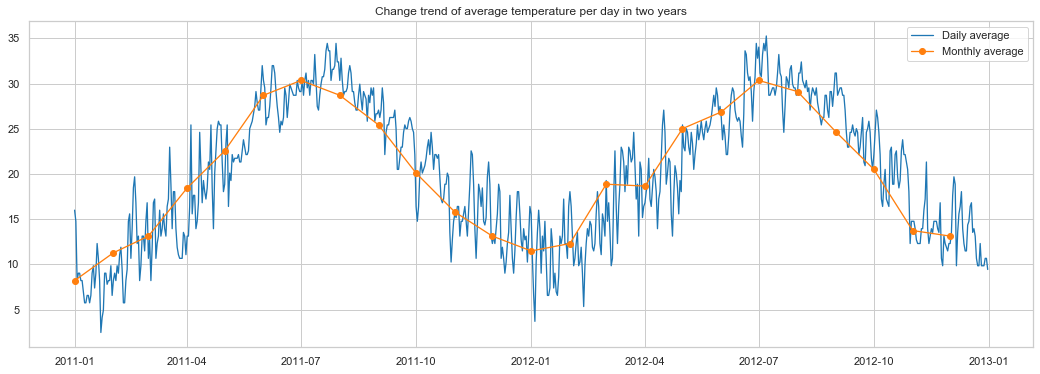

In [23]:

# 温度对租赁数量的影响

#数据按小时统计展示起来太麻烦，希望能够按天汇总取一天的气温中位数
temp_df = bike_data.groupby(['date','weekday'], as_index=False).agg({'year':'mean',
                                                                     'month':'mean',
                                                                     'temp':'median'})
#由于测试数据集中没有租赁信息，会导致折线图有断裂，所以将缺失的数据丢弃
temp_df.dropna ( axis = 0 , how ='any', inplace = True )
#预计按天统计的波动仍然很大，再按月取日平均值
temp_month = temp_df.groupby(['year','month'], as_index=False).agg({'weekday':'min',
                                                                    'temp':'median'})

#将按天求和统计数据的日期转换成datetime格式
temp_df['date']=pd.to_datetime(temp_df['date'])

#将按月统计数据设置一列时间序列
temp_month.rename(columns={'weekday':'day'},inplace=True)
temp_month['date']=pd.to_datetime(temp_month[['year','month','day']])

#设置画框尺寸
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)

#使用折线图展示总体租赁情况（count）随时间的走势
plt.plot(temp_df['date'] , temp_df['temp'] , linewidth=1.3 , label='Daily average')
ax.set_title('Change trend of average temperature per day in two years')
plt.plot(temp_month['date'] , temp_month['temp'] , marker='o', linewidth=1.3 ,
         label='Monthly average')
ax.legend()

可以看出每年的气温趋势相同随月份变化，在7月份气温最高，1月份气温最低，再看一下每小时平均租赁数量随温度变化的趋势

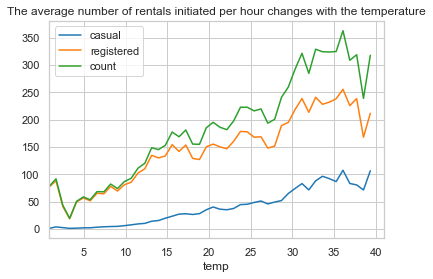

In [24]:


#按温度取租赁额平均值
temp_rentals = bike_data.groupby(['temp'], as_index=True).agg({'casual':'mean', 
                                                               'registered':'mean',
                                                               'count':'mean'})
temp_rentals .plot(title = 'The average number of rentals initiated per hour changes with the temperature')

可观察到随气温上升租车数量总体呈现上升趋势，但在气温超过35时开始下降，在气温4度时达到最低点。

### 2.2.3 湿度对租赁数量的影响

先观察湿度的走势

Text(0.5, 1.0, 'Change trend of average humidity per day in two years')

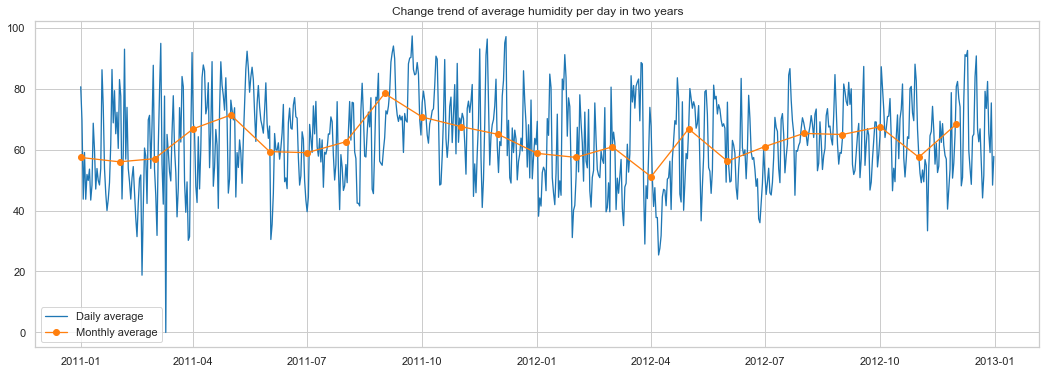

In [25]:

humidity_df = bike_data.groupby('date', as_index=False).agg({'humidity':'mean'})
humidity_df['date']=pd.to_datetime(humidity_df['date'])
#将日期设置为时间索引
humidity_df=humidity_df.set_index('date')

humidity_month = bike_data.groupby(['year','month'], as_index=False).agg({'weekday':'min',
                                                                          'humidity':'mean'})
humidity_month.rename(columns={'weekday':'day'},inplace=True)
humidity_month['date']=pd.to_datetime(humidity_month[['year','month','day']])

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)
plt.plot(humidity_df.index , humidity_df['humidity'] , linewidth=1.3,label='Daily average')
plt.plot(humidity_month['date'], humidity_month['humidity'] ,marker='o', 
         linewidth=1.3,label='Monthly average')
ax.legend()
ax.set_title('Change trend of average humidity per day in two years')

观察一下租赁人数随湿度变化趋势，按湿度对租赁数量取平均值。

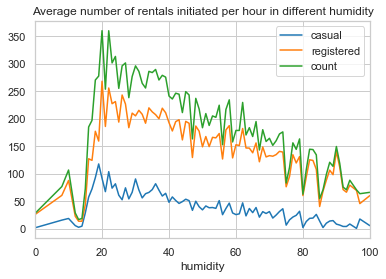

In [26]:

humidity_rentals = bike_data.groupby(['humidity'], as_index=True).agg({'casual':'mean',
                                                                       'registered':'mean',
                                                                       'count':'mean'})
humidity_rentals.plot(title = 'Average number of rentals initiated per hour in different humidity')

可以观察到在湿度20左右租赁数量迅速达到高峰值，此后缓慢递减。

### 2.2.4 年份、月份对租赁数量的影响

先观察两年时间里，总租车数量随时间变化的趋势

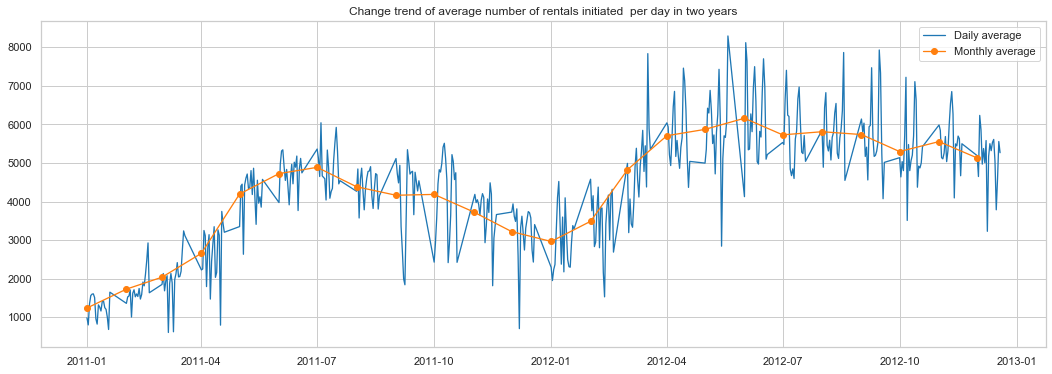

In [27]:
#数据按天汇总
counts_df = bike_data.groupby(['date','weekday'], as_index=False).agg({'year':'mean','month':'mean','casual':'sum',
                                                                      'registered':'sum', 
                                                                      'count':'sum'})
#由于测试数据集中没有租赁信息，会导致折线图有断裂，所以将缺失的数据丢弃
counts_df[counts_df['count']==0]=np.nan
counts_df.dropna ( axis = 0 , how ='all',subset=['count'], inplace = True )

#预计按天统计的波动仍然很大，再按月取日平均值
count_month = counts_df.groupby(['year','month'], as_index=False).agg({'weekday':'min','casual':'mean', 'registered':'mean', 'count':'mean'})

#将按天求和统计数据的日期转换成datetime格式
counts_df['date']=pd.to_datetime(counts_df['date'])

#将按月统计数据设置一列时间序列
count_month.rename(columns={'weekday':'day'},inplace=True)
count_month['date']=pd.to_datetime(count_month[['year','month','day']])

#设置画框尺寸
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)

#使用折线图展示总体租赁情况（count）随时间的走势
plt.plot(counts_df['date'] , counts_df['count'] , linewidth=1.3 , label='Daily average')
ax.set_title('Change trend of average number of rentals initiated  per day in two years')
plt.plot(count_month['date'] , count_month['count'] , marker='o', linewidth=1.3 , label='Monthly average')
ax.legend()

1.共享单车的租赁情况2012年整体是比2011年有增涨的；

2.租赁情况随月份波动明显；

3.数据在2011年9到12月，2012年3到9月间波动剧烈；

3.有很多局部波谷值。

### 2.2.5 季节对出行人数的影响

上图中的数据存在很多局部低谷，所以将租赁数量按季节取中位数展示，同时观察季节的温度变化

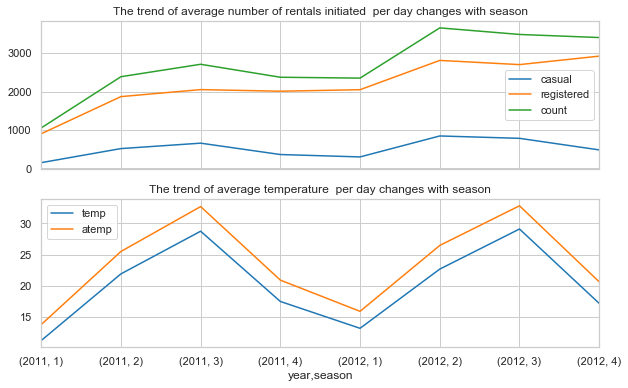

In [28]:
day_df=bike_data.groupby('date').agg({'year':'mean','season':'mean',
                                      'casual':'sum', 'registered':'sum'
                                      ,'count':'sum','temp':'mean',
                                      'atemp':'mean'})
season_df = day_df.groupby(['year','season'], as_index=True).agg({'casual':'mean', 
                                                                  'registered':'mean',
                                                                  'count':'mean'})
temp_df = day_df.groupby(['year','season'], as_index=True).agg({'temp':'mean', 
                                                                'atemp':'mean'})

fig, axes = plt.subplots(2, 1,sharex = True)

season_df.plot(figsize=(10,6) ,ax=axes[0],
                   title = 'The trend of average number of rentals initiated  per day changes with season')
temp_df.plot(ax=axes[1] , title = 'The trend of average temperature  per day changes with season')


可以看出无论是临时用户还是会员用户用车的数量都在秋季迎来高峰，而春季度用户数量最低

### 2.2.6 天气情况对出行情况的影响

考虑到不同天气的天数不同，例如非常糟糕的天气（4）会很少出现，查看一下不同天气等级的数据条数，再对租赁数量按天气等级取每小时平均值。

In [29]:

count_weather = bike_data.groupby('weather')
count_weather[['casual','registered','count']].count()

,casual,registered,count
weather,,,
1,7076,7076,7076
2,2809,2809,2809
3,853,853,853
4,1,1,1


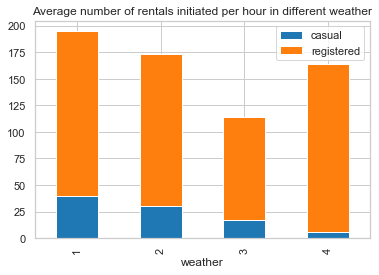

In [30]:
weather_df = bike_data.groupby('weather', as_index=True).agg({'casual':'mean', 'registered':'mean'})
weather_df.plot.bar(stacked=True,title = 'Average number of rentals initiated per hour in different weather')

观察到天气等级4的时候出行人数并不少，尤其是会员出行人数甚至比天气等级2的平均值还高，这有点反常，难道是因为这条记录恰好在下班高峰期？

由于在已知租赁情况的数据中，天气等级4的数据只有一条，所以把天气等级4的数据打印出来观察一下

In [31]:
bike_data[bike_data['weather'] == 4]

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,month,weekday,windspeed_rfr
4921,11.365,6.0,164.0,2012-01-09 18:00:00,0,86,158.0,1,8.20,4,6.0032,1,2012-01-09,18,2012,1,1,6.0032
9581,9.850,NaN,NaN,2011-01-26 16:00:00,0,93,NaN,1,9.02,4,22.0028,1,2011-01-26,16,2011,1,3,22.0028
12274,6.820,NaN,NaN,2012-01-21 01:00:00,0,86,NaN,1,5.74,4,12.9980,0,2012-01-21,1,2012,1,6,12.9980


因为这条数据在上下班高峰期，所以确实是一个异常数据

### 2.2.7 风速对出行情况的影响

先来看下两年时间风速的变化趋势

Text(0.5, 1.0, 'Change trend of average number of windspeed  per day in two years')

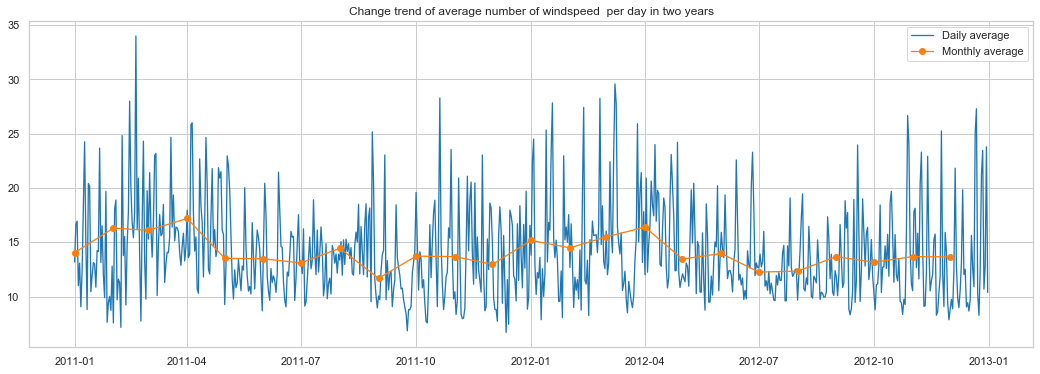

In [32]:
windspeed_df = bike_data.groupby('date',as_index = False).agg({'windspeed_rfr':'mean'})
windspeed_df['date'] = pd.to_datetime(windspeed_df['date'])

#将日期设置为时间索引
windspeed_df = windspeed_df.set_index('date')

windspeed_month = bike_data.groupby(['year','month'], as_index=False).agg({'weekday':'min','windspeed_rfr':'mean'})
windspeed_month.rename(columns={'weekday':'day'},inplace=True)
windspeed_month['date']=pd.to_datetime(windspeed_month[['year','month','day']])

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)
plt.plot(windspeed_df.index , windspeed_df['windspeed_rfr'] , linewidth=1.3,label='Daily average')
plt.plot(windspeed_month['date'], windspeed_month['windspeed_rfr'] ,marker='o', linewidth=1.3,label='Monthly average')
ax.legend()
ax.set_title('Change trend of average number of windspeed  per day in two years')

从上图可以看出，风速在2011年9月份和2011年12月到2012年3月份间波动和大，观察一下租赁人数随风速变化趋势，考虑到风速特别大的时候很少，如果取平均值会出现异常，所以按风速对租赁数量取最大值。

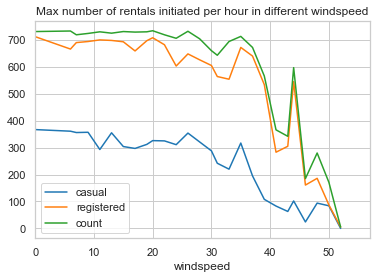

In [33]:
windspeed_rentals = bike_data.groupby(['windspeed'], as_index = True).agg({'casual':'max', 'registered':'max','count':'max'})
windspeed_rentals.plot(title = 'Max number of rentals initiated per hour in different windspeed')


租赁数量随风速越大租赁数量越少，在风速超过30的时候明显减少，但风速在风速40左右却有一次反弹，应该是和天气情况一样存在异常的数据，将异常数据打印观察一番。

In [34]:
df2=bike_data[bike_data['windspeed']>40]
df2=df2[df2['count']>400]
df2

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,month,weekday,windspeed_rfr
5721,31.06,52.0,597.0,2012-03-08 17:00:00,0,38,545.0,1,25.42,1,43.9989,1,2012-03-08,17,2012,3,4,43.9989


亦是一个下班高峰期的异常值。

### 2.2.8 日期对出行的影响

相同日期是否工作日，星期几，以及所属年份等信息是一样的，把租赁数据按天求和，其它日期类数据取平均值。

In [35]:
day_df = bike_data.groupby(['date'], as_index=False).agg({'casual':'sum','registered':'sum','count':'sum',
                                                          'workingday':'mean','weekday':'mean','holiday':'mean','year':'mean'})
day_df.head()

,date,casual,registered,count,workingday,weekday,holiday,year
0,2011-01-01,331.0,654.0,985.0,0,6,0,2011
1,2011-01-02,131.0,670.0,801.0,0,7,0,2011
2,2011-01-03,120.0,1229.0,1349.0,1,1,0,2011
3,2011-01-04,108.0,1454.0,1562.0,1,2,0,2011
4,2011-01-05,82.0,1518.0,1600.0,1,3,0,2011


In [36]:
number_pei=day_df[['casual','registered']].mean()
number_pei

casual         517.411765
registered    2171.067031
dtype: float64

Text(0.5, 1.0, 'Casual or registered in the total lease')

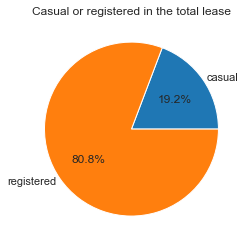

In [37]:
plt.axes(aspect='equal')  
plt.pie(number_pei, labels=['casual','registered'], autopct='%1.1f%%', pctdistance=0.6 , labeldistance=1.05 , radius=1 )  
plt.title('Casual or registered in the total lease')


工作日和休息日不同，对工作日和非工作日租赁数量取了平均值，对一周中每天的租赁数量求和。

(-1.4377319238880382,
 1.4303681868518114,
 -1.4388719783705668,
 1.4372896952393586)

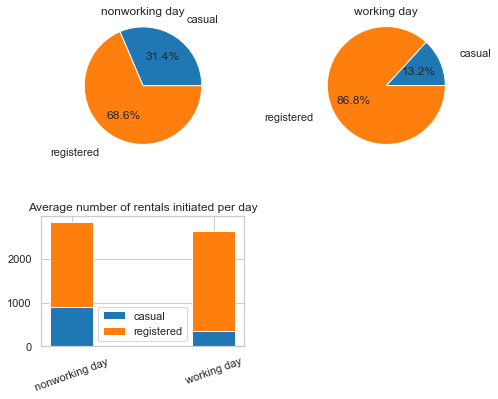

In [38]:

workingday_df=day_df.groupby(['workingday'], as_index=True).agg({'casual':'mean', 'registered':'mean'})
workingday_df_0 = workingday_df.loc[0]
workingday_df_1 = workingday_df.loc[1]

# plt.axes(aspect='equal')
fig = plt.figure(figsize=(8,6)) 
plt.subplots_adjust(hspace=0.5, wspace=0.2)     #设置子图表间隔
grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.5)   #设置子图表坐标轴 对齐

plt.subplot2grid((2,2),(1,0), rowspan=2)
width = 0.3       # 设置条宽

p1 = plt.bar(workingday_df.index,workingday_df['casual'], width)
p2 = plt.bar(workingday_df.index,workingday_df['registered'], width,bottom=workingday_df['casual'])
plt.title('Average number of rentals initiated per day')
plt.xticks([0,1], ('nonworking day', 'working day'),rotation=20)
plt.legend((p1[0], p2[0]), ('casual', 'registered'))

plt.subplot2grid((2,2),(0,0))
plt.pie(workingday_df_0, labels=['casual','registered'], autopct='%1.1f%%', pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.axis('equal') 
plt.title('nonworking day')

plt.subplot2grid((2,2),(0,1))
plt.pie(workingday_df_1, labels=['casual','registered'], autopct='%1.1f%%', pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.title('working day')
plt.axis('equal')

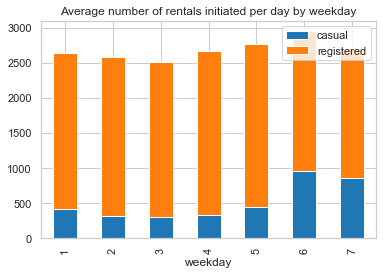

In [39]:
weekday_df= day_df.groupby(['weekday'], as_index=True).agg({'casual':'mean', 'registered':'mean'})
weekday_df.plot.bar(stacked=True , title = 'Average number of rentals initiated per day by weekday')


通过上面两个图可以看出：

1.工作日会员用户出行数量较多，临时用户出行数量较少；

2.周末会员用户租赁数量降低，临时用户租赁数量增加。



节假日在一年中数量占比非常少，先来看一每年的节假日下有几天。

In [40]:
holiday_coun=day_df.groupby('year', as_index=True).agg({'holiday':'sum'})
holiday_coun

,holiday
year,
2011,10
2012,11


假期的天数占一年天数的份额十分少，所以对假期和非假期取日平均值。

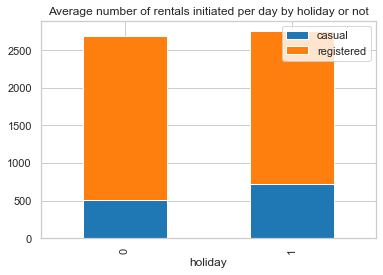

In [41]:
holiday_df = day_df.groupby('holiday', as_index=True).agg({'casual':'mean', 'registered':'mean'})
holiday_df.plot.bar(stacked=True , title = 'Average number of rentals initiated per day by holiday or not')


# 3.预测

## 3.1选择特征值
决定将时段（hour）、温度（temp）、湿度（humidity）、年份（year）、月份（month）、季节（season）、天气等级（weather）、风速（windspeed_rfr）、星期几（weekday）、是否工作日（workingday）、是否假日（holiday）， 11项作为特征值。由于CART决策树使用二分类，所以将多类别型数据使用one-hot转化成多个二分型类别。

In [57]:
dummies_month = pd.get_dummies(bike_data['month'], prefix= 'month')
dummies_season=pd.get_dummies(bike_data['season'],prefix='season')
dummies_weather=pd.get_dummies(bike_data['weather'],prefix='weather')
dummies_year=pd.get_dummies(bike_data['year'],prefix='year')
#把5个新的DF和原来的表连接起来
bike_data=pd.concat([bike_data,dummies_month,dummies_season,dummies_weather,dummies_year],axis=1)

## 3.2分离训练集和测试集

In [58]:
dataTrain = bike_data[pd.notnull(bike_data['count'])]
dataTest= bike_data[~pd.notnull(bike_data['count'])].sort_values(by=['datetime'])
datetimecol = dataTest['datetime']
yLabels=dataTrain['count']
yLabels_log=np.log(yLabels)

把不要的列丢弃

In [59]:
dropFeatures = ['casual' , 'count' , 'datetime' , 'date' , 'registered' ,
                'windspeed' , 'atemp' , 'month','season','weather', 'year' ]

dataTrain = dataTrain.drop(dropFeatures , axis=1)
dataTest = dataTest.drop(dropFeatures , axis=1)

## 3.3选择模型、训练模型

In [60]:
rfModel = RandomForestRegressor(n_estimators=10 , random_state = 42)

rfModel.fit(dataTrain , yLabels_log)

preds = rfModel.predict( X = dataTrain)

## 3.4预测测试集数据

In [58]:
predsTest= rfModel.predict(X = dataTest)

submission=pd.DataFrame({'datetime':datetimecol , 'count':[max(0,x) for x in np.exp(predsTest)]})

submission.to_csv('bike_predictions.csv',index=False)


In [62]:
bike_data.to_feather()
#export_graphviz(
#     rfModel,
#     out_file="share_bike_tree.dot",
#     feature_names=bike_data.,
#     class_names=bike_data.h,
#     rounded=True,
#     filled=True,
# )

TypeError: to_feather() missing 1 required positional argument: 'fname'